In [1]:
# Imports
from einops import rearrange, einsum
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import sys, os

sys.path.append("/pscratch/sd/j/jwl50/dyffusion")

In [2]:
model = torch.load("/pscratch/sd/j/jwl50/dyffusion/results/checkpoints/30020382/last copy.ckpt")

/tmp/ipykernel_1165099/2992083366.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/pscratch/sd/j/jwl50/dyffusion/results/checkpoints/30020382/last co

In [4]:
model = torch.load("/pscratch/sd/j/jwl50/dyffusion/results/checkpoints/30020382/nstk-MH16-DYffusion_None_epoch055_seed11 copy.ckpt")

/tmp/ipykernel_1165099/1726086179.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/pscratch/sd/j/jwl50/dyffusion/results/checkpoints/30020382/nstk-MH

In [2]:
from src.interface import get_model_and_data

/pscratch/sd/j/jwl50/conda/dyffusion/lib/python3.9/site-packages/torchvision-0.15.2a0+fa99a53-py3.9-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libnvjpeg.so.11: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/pscratch/sd/j/jwl50/conda/dyffusion/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import os
from omegaconf import DictConfig
import hydra
from hydra import initialize, compose

hydra.core.global_hydra.GlobalHydra.instance().clear()
# Ensure that Hydra doesn't change the working directory
initialize(config_path="src/configs", job_name="jupyter_notebook", version_base=None)

# Compose the config without running the main function
config = compose(config_name="main_config.yaml", overrides=["experiment=nstk_dyffusion", "logger.wandb.project=DYffusion-nstk"])

# Print or inspect the config
print(config)

{'work_dir': './results', 'ckpt_dir': '${work_dir}/checkpoints/', 'log_dir': '${work_dir}/logs/', 'print_config': True, 'ignore_warnings': True, 'test_after_training': False, 'ckpt_path': None, 'save_config_to_wandb': True, 'verbose': True, 'seed': 11, 'torch_matmul_precision': 'high', 'name': 'nstk-MH${datamodule.horizon}-DYffusion', 'name_suffix': None, 'suffix': None, 'trainer': {'_target_': 'pytorch_lightning.Trainer', 'accelerator': 'gpu', 'devices': 'auto', 'strategy': 'auto', 'min_epochs': 1, 'max_epochs': 100, 'gradient_clip_val': 1.0, 'accumulate_grad_batches': 2, 'precision': 32, 'num_sanity_val_steps': 1, 'val_check_interval': 1.0, 'deterministic': False}, 'model': {'name': '', 'verbose': '${verbose}', 'loss_function': '${diffusion.loss_function}', 'num_conditional_channels': 0, '_target_': 'src.models.unet_simple.UNet', 'dim': 256, 'outer_sample_mode': 'bilinear', 'upsample_dims': [256, 256], 'with_time_emb': True, 'input_dropout': 0.0, 'dropout': 0.15}, 'diffusion': {'time

In [4]:
model, datamodule = get_model_and_data(config)

/pscratch/sd/j/jwl50/dyffusion/src/interface.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path, map_location=device)


In [5]:
model

MultiHorizonForecastingDYffusion(
  (model): DYffusion(
    (criterion): L1Loss()
    (model): UNet(
      (criterion): L1Loss()
      (upsampler): Upsample(size=(256, 256), mode='bilinear')
      (time_emb_mlp): Sequential(
        (0): SinusoidalPosEmb()
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=512, out_features=512, bias=True)
      )
      (init_conv): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
      (dropout_input): Dropout(p=0.0, inplace=False)
      (input_ops): ModuleList(
        (0): UNetBlock(
          (time_mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=1024, bias=True)
          )
          (ops): Sequential(
            (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (act): LeakyR

In [9]:
import h5py
import numpy as np
import torch
from einops import rearrange
import os

class NSTK_FC(torch.utils.data.Dataset):
    def __init__(self,
                 num_pred_steps=1, 
                 patch_size=256, 
                 stride=256,
                 step=0,
                 Reynolds_number=16000,
                 train=False,
                 in_domain=False,
                scratch_dir='/global/cfs/cdirs/m4633/foundationmodel/nskt_tensor/'):
        super(NSTK_FC, self).__init__()
        
        if in_domain:
            self.paths = [
                os.path.join(scratch_dir, '1000_2048_2048_seed_2150.h5'),
                os.path.join(scratch_dir, '8000_2048_2048_seed_2150.h5'),
                os.path.join(scratch_dir, '16000_2048_2048_seed_2150.h5')
            ]
            self.RN = [1000, 8000, 16000]
        else:
            self.paths = [
                os.path.join(scratch_dir, '1000_2048_2048_seed_3407.h5'),
                os.path.join(scratch_dir, '8000_2048_2048_seed_3407.h5'),
                os.path.join(scratch_dir, '12000_2048_2048_seed_3407.h5'),
                os.path.join(scratch_dir, '16000_2048_2048_seed_3407.h5'),
                os.path.join(scratch_dir, '24000_2048_2048_seed_3407.h5'),
                os.path.join(scratch_dir, '32000_2048_2048_seed_3407.h5'),
                os.path.join(scratch_dir, '36000_2048_2048_seed_3407.h5')
            ]
            self.RN = [1000, 8000, 12000, 16000, 24000, 32000, 36000]
        
        self.num_pred_steps = num_pred_steps
        self.train = train
        self.patch_size = patch_size
        self.stride = stride
        self.step = step
        self.Reynolds_number = Reynolds_number

        # Open the appropriate HDF5 file based on Reynolds number
        self.dataset = None
        for path, rn in zip(self.paths, self.RN):
            if self.Reynolds_number == rn:
                self.dataset = h5py.File(path, 'r')['w']
                self.data_shape = self.dataset.shape
                break
        
        if self.dataset is None:
            raise ValueError(f"Invalid Reynolds_number: {self.Reynolds_number}. Dataset not found.")
        
        self.max_row = (self.data_shape[1] - self.patch_size) // self.stride + 1
        self.max_col = (self.data_shape[2] - self.patch_size) // self.stride + 1    
        self.num_patches_per_image = self.max_row * self.max_col

    def __getitem__(self, index):
        
        index = index * 4 + 1
        
        # Calculate image and patch indices
        num_patches_per_row = self.max_col
        image_idx = index // self.num_patches_per_image
        patch_idx = index % self.num_patches_per_image
        
        patch_row = (patch_idx // num_patches_per_row) * self.stride
        patch_col = (patch_idx % num_patches_per_row) * self.stride   
        
        # Select dataset based on Reynolds_number
        dataset = self.dataset
        shift = self.step
        
        # Extract the patch and target
        X = dataset[image_idx:image_idx+shift+1, patch_row:(patch_row + self.patch_size), patch_col:(patch_col + self.patch_size)]
        X = rearrange(X, "t lat lon -> 1 t 1 lat lon")
        
        return {"dynamics": torch.tensor(X)}

    def __len__(self):
        return self.num_patches_per_image * 250  # Adjust this value based on your specific needs


In [10]:
class Config:
    def __init__(
        self,
        batch_size=128,
        mode='forecast',
        pred_step=16,
        horizon=1,
        Reynolds_number=16000,
        target_resolution=256,
        stride=256,
        factor=8,
        prediction_type='v',
        time_steps=2,
        num_pred_steps=3,
        base_width=64,
        num_samples=16,
    ):
        self.batch_size = batch_size
        self.mode = mode
        self.pred_step = pred_step
        self.horizon = horizon
        self.Reynolds_number = Reynolds_number
        self.target_resolution = target_resolution
        self.stride = stride
        self.factor = factor
        self.prediction_type = prediction_type
        self.time_steps = time_steps
        self.num_pred_steps = num_pred_steps
        self.base_width = base_width
        self.num_samples = num_samples

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 27 13:10:38 2024

@author: ben
"""


import os
import torch


import numpy as np

#from src.get_data import NSTK_SR as NSTK
from torch.utils.data import Dataset, DataLoader

import scipy.stats

import h5py

def evaluate(model, batch_size=32, pred_step=16, Reynolds_number=12000, num_samples=16, stride=1024,):

    args = Config(
        batch_size=batch_size,
        pred_step=pred_step,
        Reynolds_number=Reynolds_number,
        num_samples=num_samples,
        stride=stride,
    )

    # set seed
    seed = 0
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

    model.to('cuda')
    model.eval()

    if args.mode == 'forecast':

        # Get test data
        test_set = NSTK_FC(
            train=False,
            step = args.pred_step,
            Reynolds_number = args.Reynolds_number,
            stride=stride,
        )  # load your dataset


        testloader = DataLoader(
            test_set,
            batch_size=1, # args.batch_size,
            pin_memory=True,
            shuffle=False,
        ) 

        RFNE_error = []
        R2s = []
   
        with torch.no_grad():
            model.eval()               

            for i, batch in enumerate(testloader):

                    print(i)
                    dynamics = batch["dynamics"][0].to(device="cuda") # (1, pred_step+1, 1, 256, 256)
                    print(f"Dynamics: {dynamics.shape}")
                    x_initial = dynamics[:, 0] # (1, 1, 256, 256)
                    targets = dynamics[:, 1:] # (1, pred_step, 1, 256, 256)
                    print(f"x_initial: {x_initial.shape}")
                    print(f"targets: {targets.shape}")
                    
                    preds = [[] for _ in range(args.pred_step)]
                    
                    for _ in range(args.num_samples):
                        # Sample from model
                        predictions = model.sample(
                            x_initial,
                            # num_samples=args.num_samples, # TODO for some reason num_samples doesn't work in the code
                        )
                        # with torch.no_grad():
                        #     _, predictions, _ = model.sample_loop(
                        #         x_initial,
                        #         num_predictions=args.num_samples, # TODO for some reason num_samples doesn't work in the code
                        #     )
                        # preds is a dict with keys "t1_preds", ..., "t{pred_step}_preds"
                    
                        # Process into list
                        for pred_step in range(args.pred_step):
                            pred_step_key = f"t{pred_step+1}_preds"
                            preds[pred_step].append(predictions[pred_step_key])
                            
                    for pred_step in range(args.pred_step):
                        preds[pred_step] = torch.cat(preds[pred_step]) # (pred_step, 1, 256, 256)

                    # Number of time steps
                    for p in range(targets.shape[1]):
                    
                        RFNE_error_at_time_p = []
                        cc_error_at_time_p = []
                        # Number of samples
                        for j in range(args.num_samples):

                            target = targets[:, p].cpu().detach().numpy()
                            prediction = preds[p].cpu().detach().numpy()
                            # print(f"Target: {target.shape}") # (1, 1, 256, 256)
                            # print(f"Pred: {prediction.shape}") # (16, 1, 256, 256)

                            # compute RFNE 
                            error = np.linalg.norm(prediction[j,0,:,:] - target[0,0,:,:]) / np.linalg.norm(target[0,0,:,:])
                            RFNE_error_at_time_p.append(error)

                            # compute correlation coef
                            cc = scipy.stats.pearsonr(prediction[j,0,:,:].flatten(), target[0,0,:,:].flatten())[0]
                            cc_error_at_time_p.append(cc)

                        RFNE_error.append(RFNE_error_at_time_p)   
                        R2s.append(cc_error_at_time_p)

                    #print(np.mean(np.vstack(RFNE_error), axis=0 ))


#                     if i == 0:
#                         samples = {
#                             'conditioning_snapshots': conditioning_snapshots.cpu().detach().numpy(),
#                             'targets': targets,
#                             'predictions': preds
#                             }

#                         if not os.path.exists("./samples"):
#                                     os.makedirs("./samples")


#                         np.save(f'samples/samples_forecast_RE_{args.Reynolds_number}_SR_{args.sampler}_{args.time_steps}_unet_{args.base_width}_' + str(i+1) + '.npy', samples)
#                         print('saved samples')

                    if i == 320:
                      break

#         avg_RFNE =  np.mean(np.vstack(RFNE_error), axis=0 )                  
#         print(f'Average RFNE={repr(avg_RFNE)}')   

#         avg_R2 =  np.mean(np.vstack(R2s), axis=0 )                  
#         print(f'Average Pearson correlation coefficients={repr(avg_R2)}')   
        
        return RFNE_error, R2s


In [ ]:
RFNE_error, R2s = evaluate(
    model.model,
    batch_size=32,
    pred_step=16,
    Reynolds_number=1000,
    num_samples=1,
    stride=1024,
)

0
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

1
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

2
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

3
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

4
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

5
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

6
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

7
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

8
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

9
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

10
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

11
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

12
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

13
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

14
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

15
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

16
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

17
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

18
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

19
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

20
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

21
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

22
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

23
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

24
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

25
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

26
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

27
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

28
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

29
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

30
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

31
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

32
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

33
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

34
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

35
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

36
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

37
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

38
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

39
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

40
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

41
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

42
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

43
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

44
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

45
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

46
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

47
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

48
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

49
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

50
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

51
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

52
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

53
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

54
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

55
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

56
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

57
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

58
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

59
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

60
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

61
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

62
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

63
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

64
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

65
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

66
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

67
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

68
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

69
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

70
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

71
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

72
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

73
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

74
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

75
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

76
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

77
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

78
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

79
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

80
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

81
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

82
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

83
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

84
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

85
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

86
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

87
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

88
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

89
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

90
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

91
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

92
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

93
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

94
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

95
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

96
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

97
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

98
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

99
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

100
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

101
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

102
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

103
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

104
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

105
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

106
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

107
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

108
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

109
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

110
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

111
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

112
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

113
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

114
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

115
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

116
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

117
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

118
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

119
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

120
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

121
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

122
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

123
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

124
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

125
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

126
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

127
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

128
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

129
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

130
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

131
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

132
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

133
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

134
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

135
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

136
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

137
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

138
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

139
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

140
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

141
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

142
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

143
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

144
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

145
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

146
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

147
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

148
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

149
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

150
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

151
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

152
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

153
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

154
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

155
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

156
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

157
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

158
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

159
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

160
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

161
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

162
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

163
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

164
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

165
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

166
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

167
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

168
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

169
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

170
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

171
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

172
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

173
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

174
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

175
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

176
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

177
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

178
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

179
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

180
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

181
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

182
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

183
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

184
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

185
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

186
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

187
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

188
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

189
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

190
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

191
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

192
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

193
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

194
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

195
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

196
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

197
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

198
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

199
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

200
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

201
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

202
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

203
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

204
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

205
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

206
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

207
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

208
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

209
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

210
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

211
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

212
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

213
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

214
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

215
Dynamics: torch.Size([1, 17, 1, 256, 256])
x_initial: torch.Size([1, 1, 256, 256])
targets: torch.Size([1, 16, 1, 256, 256])


Sampling time step:   0%|          | 0/16 [00:00<?, ?it/s]

In [88]:
np_RFNE_error = np.vstack(RFNE_error)
np_RFNE_error = np_RFNE_error.reshape(11, 16, 16).transpose(1, 0, 2).reshape(16, -1)
print(np_RFNE_error.shape)

(16, 176)


In [89]:
np_R2s = np.vstack(R2s)
np_R2s = np_R2s.reshape(11, 16, 16).transpose(1, 0, 2).reshape(16, -1)
print(np_R2s.shape)

(16, 176)


In [91]:
avg_RFNE = np.mean(np.vstack(np_RFNE_error), axis=1)
print(f'Average RFNE={repr(avg_RFNE)}')
avg_R2 = np.mean(np.vstack(np_R2s), axis=1)
print(f'Average Pearson correlation coefficients={repr(avg_R2)}')

Average RFNE=array([0.13488062, 0.27871546, 0.40462962, 0.49019563, 0.5647348 ,
       0.63337743, 0.70332617, 0.7642807 , 0.821614  , 0.8709077 ,
       0.90735435, 0.93428326, 0.96080035, 0.97868896, 0.9941708 ,
       1.047635  ], dtype=float32)
Average Pearson correlation coefficients=array([ 0.99209387,  0.9642168 ,  0.92269853,  0.88827724,  0.85572324,
        0.82437783,  0.78993797,  0.76310369,  0.73490403,  0.69780034,
        0.66091602,  0.62717859,  0.54998335,  0.46833645,  0.23610107,
       -0.02022874])


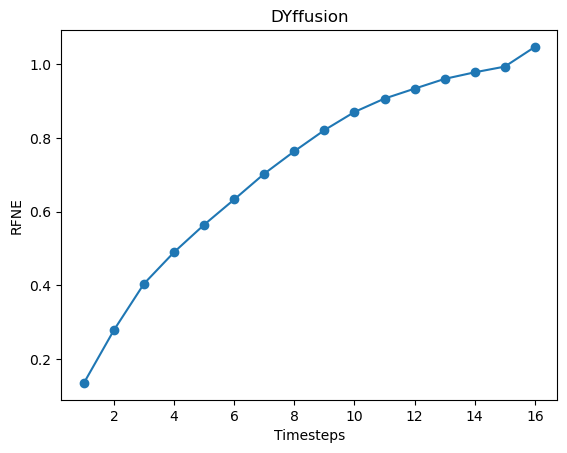

In [98]:
plt.plot(range(1, len(avg_RFNE)+1), avg_RFNE)
plt.scatter(range(1, len(avg_RFNE)+1), avg_RFNE)
plt.xlabel("Timesteps")
plt.ylabel("RFNE")
plt.title("DYffusion")
plt.savefig("/pscratch/sd/j/jwl50/dyffusion/090524_RFNE.png")
plt.show()

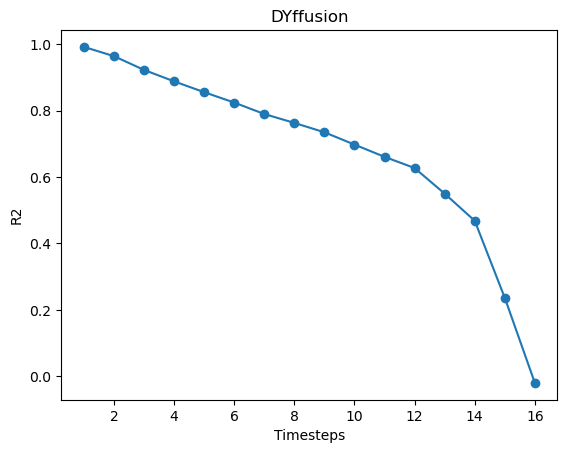

In [97]:
plt.plot(range(1, len(avg_R2)+1), avg_R2)
plt.scatter(range(1, len(avg_R2)+1), avg_R2)
plt.xlabel("Timesteps")
plt.ylabel("R2")
plt.title("DYffusion")
plt.savefig("/pscratch/sd/j/jwl50/dyffusion/090524_R2.png")
plt.show()

## Dev

In [ ]:
# Get test data
test_set = NSTK_FC(
   train=False,
   step = 16,
   Reynolds_number = 12000,
)  # load your dataset

In [12]:
batch = test_set.__getitem__(0)
dynamics = batch["dynamics"]
print(dynamics.shape)
x_first = dynamics[:, 0, ...].to(device="cuda")
x_last = dynamics[:, 1, ...].to(device="cuda")
# inputs, extra_kwargs = model.get_inputs_and_extra_kwargs(batch, split="val", ensemble=False)
# inputs = inputs.to(device="cuda")
# print(x_last.shape)
# print(inputs.shape)
# print(extra_kwargs)
# loss = model.model.get_loss(inputs=inputs, targets=x_last, **extra_kwargs)
loss = model.model.get_loss(inputs=x_first, targets=x_last)
print(loss)

torch.Size([1, 16, 1, 256, 256])
{'loss': tensor(6.6766, device='cuda:0', grad_fn=<AddBackward0>), 'train/loss_forward': tensor(6.6772, device='cuda:0', grad_fn=<MeanBackward0>), 'train/loss_forward2': tensor(6.6760, device='cuda:0', grad_fn=<MeanBackward0>)}
